In [12]:
# dependencies
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [13]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator

from config.paths import *

In [14]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

### Data Ingestion

In [18]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
weather = weather_data._get_processed_weather('weather')
wind = weather_data._get_processed_weather('wind')
hydro = weather_data._get_processed_weather('hydro')
solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-14 23:45:00
rtm data updated up to:  14-01-2024 00:15


KeyError: 'data_1h'

### Feature Engineering

In [5]:
rtm = featured_data.shift_date(rtm, 0) 
weather = featured_data.shift_date(weather, -1)
hydro = featured_data.shift_date(hydro, -1) 
solar = featured_data.shift_date(solar, -1) 
wind = featured_data.shift_date(wind, -1)

data = featured_data.merge_dataframes([dam, rtm, weather, hydro, solar, wind])

In [6]:
data_for_training = featured_data._get_features(data, weather, data_type = 'dam')
featured_data._save_features(data_for_training, os.path.join(processed_data_path, 'training_data'))

### Model Building

In [5]:
data = pd.read_pickle(os.path.join(processed_data_path, 'training_data'))

In [6]:
# Set the desired cutoff dates
training_upto = data.iloc[int(data.shape[0]*0.7)]['datetime'].strftime('%Y-%m-%d')      # 70% data for training
validation_upto = data.iloc[-96]['datetime'].strftime('%Y-%m-%d')        # last day data for testing

# Split the data
X_train, y_train, X_valid, y_valid, X_test, y_test = build_model._split_data(data, training_upto, validation_upto)

In [7]:
# trail and error
n_trials = 50
n_features = 25

In [8]:
best_features, best_params = build_model._features_n_params(X_train, y_train, X_valid, y_valid, n_trials, n_features)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=14.539904661691253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.539904661691253
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=5600, m

### Model Training

In [24]:
# training upto this date
training_upto = data[::96]['datetime'].iloc[-1].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(data, training_upto, validation_upto)

In [25]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression', model_type = 'dam_forecast')

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.710191280264093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.710191280264093
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


In [26]:
lower_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', model_type = 'dam_lower', alpha = 0.1)

In [27]:
upper_model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'quantile', model_type = 'dam_upper', alpha = 0.9)

### Model Evaluation

In [28]:
evaluator = ModelEvaluator(model, best_features)

Evaluating on train data:
MAPE: 7.6499999999999995


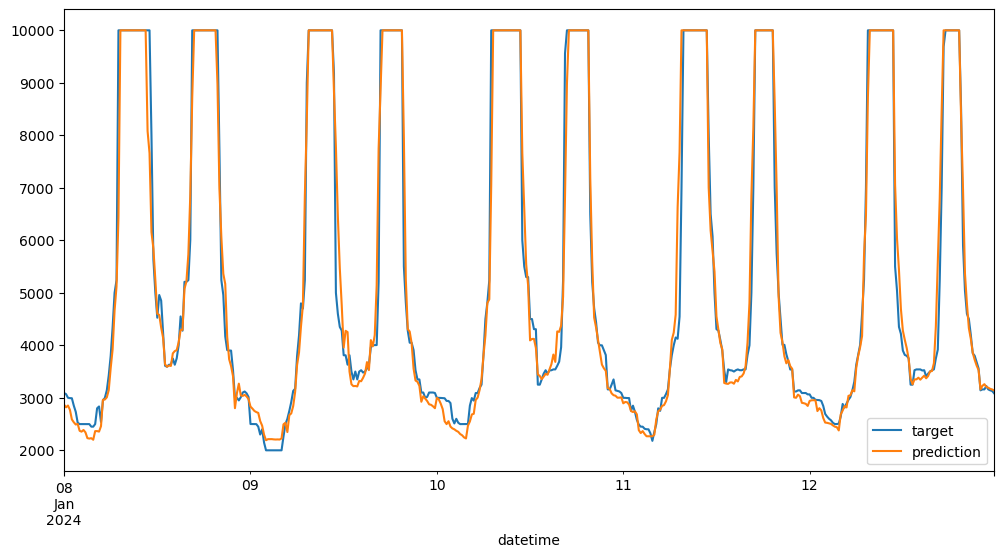

In [32]:
evaluator.evaluate_on_data(X_train, y_train, 'train', 5)

Evaluating on test data:
MAPE: 5.96


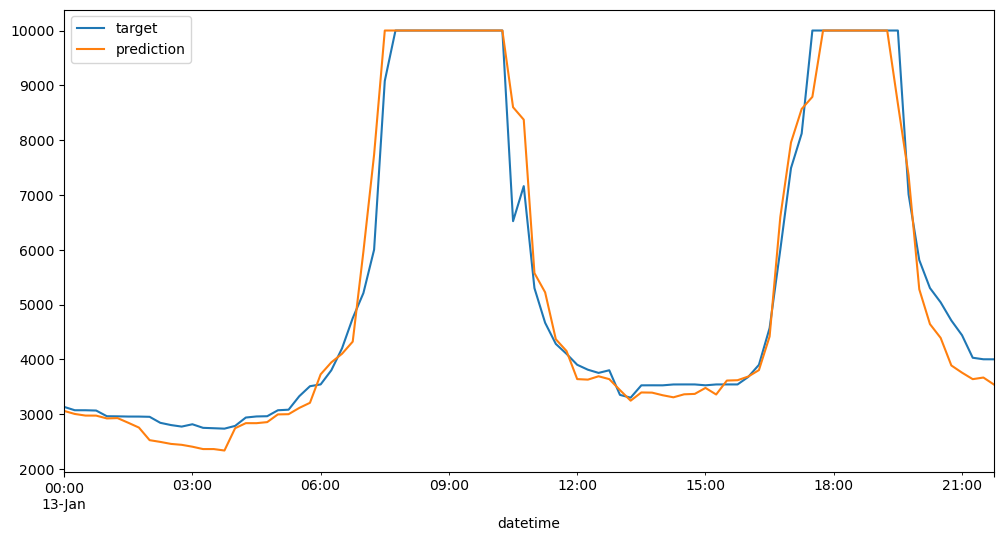

In [31]:
evaluator.evaluate_on_data(X_test, y_test, 'test', 1)